**Data Preprocessing - Rafi**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler

In [2]:
# read values and labels, group by id to ensure columns are matching
values=pd.read_csv('training_values.csv')
labels=pd.read_csv('training_labels.csv')
df = values.merge(labels, on='id')

In [3]:
# dataset uses 0.0 to represent NaN values, replace it with np.nan to allow us to impute data easier
df['gps_height'].replace(0.0, np.nan, inplace=True)
df['population'].replace(0.0, np.nan, inplace=True)
df['amount_tsh'].replace(0.0, np.nan, inplace=True)
df['longitude'].replace(0.0, np.nan, inplace=True)
df['latitude'].replace(0.0, np.nan, inplace=True)
df['construction_year'].replace(0.0, np.nan, inplace=True)

In [4]:
# create two new variables, waterpoint_age and days_since_recorded as models do not like datetime data
current_year = datetime.datetime.now().year
df['waterpoint_age'] = current_year - df['construction_year']
current_date = datetime.datetime.now()
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['days_since_recorded'] = (current_date - df['date_recorded']).dt.days
df.drop('date_recorded',axis=1,inplace=True)
df.drop('construction_year',axis=1,inplace=True)

In [5]:
# fill na values in true / false columns as false
df['permit'] = df['permit'].fillna(False)
df['public_meeting'] = df['public_meeting'].fillna(False)

In [6]:
# turn all string values lowercase for consistency 
string_columns = df.select_dtypes(include='object').columns
df[string_columns] = df[string_columns].apply(lambda x: x.str.lower())
df["funder"].fillna("other", inplace=True)
df["subvillage"].fillna("other", inplace=True)
df["wpt_name"].fillna("other", inplace=True)
df["scheme_management"].fillna("other", inplace=True)
df['installer'].fillna("other", inplace=True)
df["scheme_name"].fillna("other", inplace=True)

In [7]:
# drop uneccesary features
df.drop('management_group',axis=1,inplace=True) # similar values found in 'managment'
df.drop('extraction_type_group',axis=1,inplace=True) # similar values found in 'extraction_type_class'
df.drop('scheme_name',axis=1,inplace=True) # similar values found in 'scheme_managment'
df.drop('payment',axis=1,inplace=True) # similar values found in 'payment_type'
df.drop('quality_group',axis=1,inplace=True) # similar values found in 'quality_group'
df.drop('quantity_group',axis=1,inplace=True) # similar values found in 'quantity'
df.drop('source_type',axis=1,inplace=True) # similar values found in 'source'
df.drop('waterpoint_type_group',axis=1,inplace=True) # similar values found in 'waterpoint_type'
df.drop('ward',axis=1,inplace=True)
df.drop('installer',axis=1,inplace=True) 
df.drop('permit', axis=1, inplace=True)
df.drop('id',axis=1,inplace=True)

In [8]:
train = df.copy()
label = train.pop('status_group')

In [9]:
# turn all categorical values into numerical so it works with models correctly
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in train.columns:
    if train[column_name].dtype == object:
        train[column_name] = le.fit_transform(train[column_name])
    else:
        pass

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=42)

In [11]:
# data imputation - replace NaN values for numerical column with mean of its region (or just mean if region data doesnt exist)
X_train["gps_height"].fillna(X_train.groupby(['region'])["gps_height"].transform("mean"), inplace=True)
X_train["gps_height"].fillna(X_train["gps_height"].mean(), inplace=True)

X_train["population"].fillna(X_train.groupby(['region'])["population"].transform("mean"), inplace=True)
X_train["population"].fillna(X_train["population"].mean(), inplace=True)

X_train["amount_tsh"].fillna(X_train.groupby(['region'])["amount_tsh"].transform("mean"), inplace=True)
X_train["amount_tsh"].fillna(X_train["amount_tsh"].mean(), inplace=True)

X_train["waterpoint_age"].fillna(X_train.groupby(['region'])["waterpoint_age"].transform("mean"), inplace=True)
X_train["waterpoint_age"].fillna(X_train["waterpoint_age"].mean(), inplace=True)

X_train["longitude"].fillna(X_train.groupby(['region'])["longitude"].transform("mean"), inplace=True)

In [12]:
# do the same for test values - do seperate to ensure no data leakage
X_test["gps_height"].fillna(X_test.groupby(['region'])["gps_height"].transform("mean"), inplace=True)
X_test["gps_height"].fillna(X_test["gps_height"].mean(), inplace=True)

X_test["population"].fillna(X_test.groupby(['region'])["population"].transform("mean"), inplace=True)
X_test["population"].fillna(X_test["population"].mean(), inplace=True)

X_test["amount_tsh"].fillna(X_test.groupby(['region'])["amount_tsh"].transform("mean"), inplace=True)
X_test["amount_tsh"].fillna(X_test["amount_tsh"].mean(), inplace=True)

X_test["waterpoint_age"].fillna(X_test.groupby(['region'])["waterpoint_age"].transform("mean"), inplace=True)
X_test["waterpoint_age"].fillna(X_test["waterpoint_age"].mean(), inplace=True)

X_test["longitude"].fillna(X_test.groupby(['region'])["longitude"].transform("mean"), inplace=True)

**Model Training and Results - Rafi**

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV 
from sklearn.metrics import accuracy_score


In [ ]:
model_rfc = RandomForestClassifier()

param_grid = { 
    'n_estimators': [50, 250], 
    'max_features': ['sqrt', 'log2'], 
    'n_jobs': [-1] , 
} 

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid, cv = 2) 
grid_search.fit(X_train, y_train) 
print(grid_search.best_estimator_) 

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
columns = ['param_n_estimators', 'param_max_features', 'mean_test_score', 'std_test_score']
results_sorted = results[columns].sort_values(by='mean_test_score', ascending=False)
results_sorted.head(10)




In [ ]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=250,max_features='log2', n_jobs = -1, bootstrap= True)
scores = cross_val_score(rf, X_train, y_train, cv=5)
# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Calculate and print the mean score
print("Mean accuracy:", scores.mean())

In [14]:
from sklearn.metrics import accuracy_score
best = RandomForestClassifier(n_estimators=00,max_features='log2', n_jobs = -1, bootstrap= True)
best.fit(X_train, y_train)
best_y_pred = best.predict(X_test)
accuracy = accuracy_score(y_test, best_y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.814057239057239


In [20]:
from sklearn.metrics import f1_score
f1_score(y_test, best_y_pred, average='weighted')

0.8068405400047539

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, best_y_pred, normalize='true')

array([[0.90103763, 0.02183677, 0.0771256 ],
       [0.52643948, 0.32784959, 0.14571093],
       [0.20297463, 0.01531059, 0.78171479]])

In [26]:
X_test_plot = X_test.copy()

X_test_plot['preds'] = best_y_pred
X_test_plot['labels'] = y_test
X_test_plot['correct_classification'] = X_test_plot['preds'] == X_test_plot['labels']

In [31]:
X_test_plot['correct_classification'] = X_test_plot['preds'] == X_test_plot['labels']

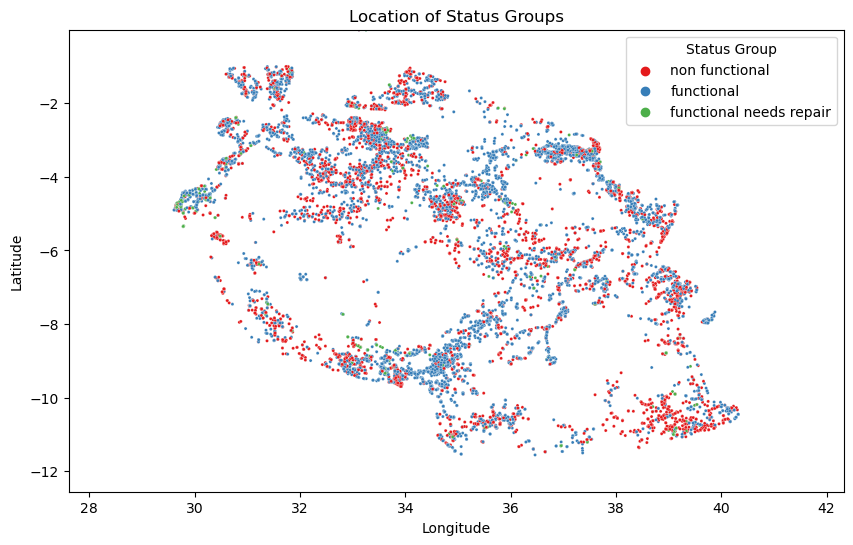

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

lat_min = X_test_plot['latitude'].min() - 1
lat_max = X_test_plot['latitude'].max()
lon_min = X_test_plot.longitude[X_test_plot.longitude!=0].min() - 2
lon_max = X_test_plot['longitude'].max() + 2


plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='preds', data=X_test_plot, palette='Set1', s=5)

# Set the range of latitude and longitude using computed min and max values
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title('Location of Status Groups')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Status Group')
plt.show()

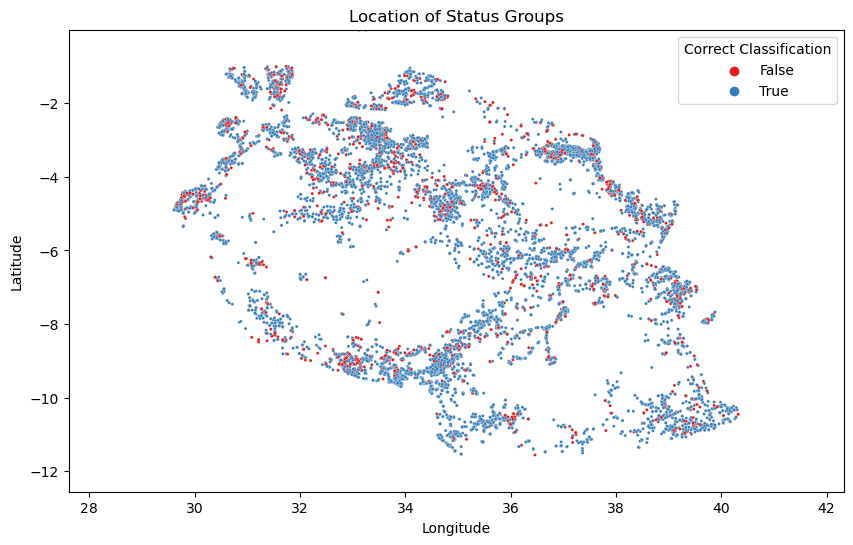

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='correct_classification', data=X_test_plot, palette='Set1', s=5)

# Set the range of latitude and longitude using computed min and max values
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title('Location of Status Groups')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Correct Classification')
plt.show()

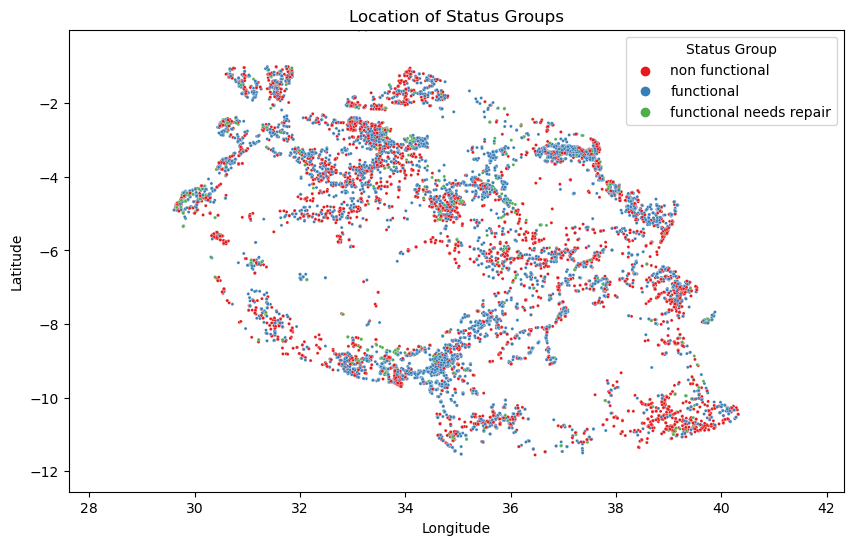

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='labels', data=X_test_plot, palette='Set1', s=5)

# Set the range of latitude and longitude using computed min and max values
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title('Location of Status Groups')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Status Group')
plt.show()

In [ ]:
grid = {'max_depth': [3,4,5,6],'n_estimators':[100, 200, 300, 400, 500, 1000], 'verbose':[False]}
gscv = GridSearchCV (estimator = catboost, param_grid = grid, scoring ='accuracy', cv = 5)
gscv.fit(X_train, y_train)
#returns the estimator with the best performance
print(gscv.best_estimator_)

#returns the best score
print(gscv.best_score_)

#returns the best parameters
print(gscv.best_params_)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=500).fit(X_train, y_train)
y_test_mlp = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_test_mlp)
print("Accuracy:", accuracy)

In [24]:
!pip3 install catboost

  Using cached catboost-1.2.5.tar.gz (69.6 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for catboost (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [40 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-10.9-x86_64-cpython-311
      creating build/lib.macosx-10.9-x86_64-cpython-311/catboost
      copying catboost/monoforest.py -> build/lib.macosx-10.9-x86_64-cpython-311/catboost
      copying catboost/plot_helpers.

In [25]:
from catboost import CatBoostClassifier
catboost = CatBoostClassifier()
catboost.fit(X_train, y_train,verbose=False)
y_pred_cb = catboost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_cb)
print("Accuracy:", accuracy)

ModuleNotFoundError: No module named 'catboost'

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators = 1000)
gb_model = gb.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_gb)
print("Accuracy:", accuracy)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

from sklearn.decomposition import PCA
pca = PCA(n_components=15)
pca_X_train = pca.fit_transform(scaled_X_train)
pca_X_test = pca.fit_transform(scaled_X_test)

In [ ]:
# PCA TESTING
model_rfc_pca = RandomForestClassifier(n_estimators=250, n_jobs = -1)
model_rfc_pca.fit(pca_X_train,y_train)
y_pred = model_rfc_pca.predict(pca_X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
X_train.info()

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred_gnb = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_gnb)
print("Accuracy:", accuracy)

In [ ]:
catboost_pca = CatBoostClassifier()
catboost_pca.fit(pca_X_train, y_train,verbose=False)
y_pred_cb = catboost_pca.predict(pca_X_test)
accuracy = accuracy_score(y_test, y_pred_cb)
print("Accuracy:", accuracy)

In [ ]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(train, label, test_size=0.3, random_state=42)

In [ ]:
X_train_m["gps_height"].fillna(X_train_m.groupby(['region'])["gps_height"].transform("median"), inplace=True)
X_train_m["gps_height"].fillna(X_train_m["gps_height"].mean(), inplace=True)

X_train_m["population"].fillna(X_train_m.groupby(['region'])["population"].transform("median"), inplace=True)
X_train_m["population"].fillna(X_train_m["population"].median(), inplace=True)

X_train_m["amount_tsh"].fillna(X_train_m.groupby(['region'])["amount_tsh"].transform("median"), inplace=True)
X_train_m["amount_tsh"].fillna(X_train_m["amount_tsh"].median(), inplace=True)


X_train_m["waterpoint_age"].fillna(X_train_m.groupby(['region'])["waterpoint_age"].transform("median"), inplace=True)
X_train_m["waterpoint_age"].fillna(X_train_m["waterpoint_age"].median(), inplace=True)

X_train_m["longitude"].fillna(X_train_m.groupby(['region'])["longitude"].transform("median"), inplace=True)

In [ ]:
X_test_m["gps_height"].fillna(X_test_m.groupby(['region'])["gps_height"].transform("median"), inplace=True)
X_test_m["gps_height"].fillna(X_test_m["gps_height"].median(), inplace=True)

X_test_m["population"].fillna(X_test_m.groupby(['region'])["population"].transform("median"), inplace=True)
X_test_m["population"].fillna(X_test_m["population"].median(), inplace=True)

X_test_m["amount_tsh"].fillna(X_test_m.groupby(['region'])["amount_tsh"].transform("median"), inplace=True)
X_test_m["amount_tsh"].fillna(X_test_m["amount_tsh"].median(), inplace=True)


X_test_m["waterpoint_age"].fillna(X_test_m.groupby(['region'])["waterpoint_age"].transform("median"), inplace=True)
X_test_m["waterpoint_age"].fillna(X_test_m["waterpoint_age"].median(), inplace=True)

X_test_m["longitude"].fillna(X_test_m.groupby(['region'])["longitude"].transform("median"), inplace=True)

In [ ]:
rf_median = RandomForestClassifier(n_estimators=250,max_features='log2', n_jobs = -1)
rf_median.fit(X_train_m,y_train_m)
y_pred_median = rf_median.predict(X_test_m)
accuracy = accuracy_score(y_test_m, y_pred_median)
print("Accuracy:", accuracy)

In [ ]:
rf = RandomForestClassifier(n_estimators=250,max_features='log2', n_jobs = -1)
rf.fit(X_train,y_train)
y_pred = rf_median.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_median)
print("Accuracy:", accuracy)